In [1]:
import os
from keras.models import Model, load_model
import keras.losses
import tensorflow as tf
import tensorflow_probability as tfp

import numpy as np

import time


def custom_loss(y_true, y_predicted):
    mean, log_sigma = tf.split(y_predicted, 2, axis=-1)
    y_true_value, temp = tf.split(y_true, 2, axis=-1)
    sigma = tf.nn.softplus(log_sigma)
    dist = tfp.distributions.MultivariateNormalDiag(loc=mean, scale_diag=sigma)
    loss = -tf.reduce_mean(dist.log_prob(y_true_value))
    return loss


root_path = f'/home/yigit/phd/yigit_phd_thesis/cnmp/output/sfm/small_env_changing_s_g/'
test_id = '1607473236'
model_path = f'{root_path}{test_id}/'

data_root = "/home/yigit/phd/yigit_phd_thesis/cnmp/data/sfm/small_env_changing_s_g/"
data_path = f"{data_root}demonstrations/"
output_path = f'{data_root}dim_reduction/'

keras.losses.custom_loss = custom_loss
model = load_model(f'{model_path}cnmp_best_validation.h5', custom_objects={'tf': tf})

latent_layer = Model(inputs=model.input, outputs=model.get_layer('obs_mlp').get_output_at(-1))

Using TensorFlow backend.


Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [2]:
def select_data(X, Y, G):
    idx_left = np.where(np.logical_and(gamma[:,0,0] > 1.97, gamma[:,0,0] < 2.03))[0][0]
    idx_right = np.where(np.logical_and(gamma[:,0,0] > -2.03, gamma[:,0,0] < -1.97))[0][0]
    
    x=np.zeros((2, X.shape[1], X.shape[2]))
    y=np.zeros((2, Y.shape[1], Y.shape[2]))
    g=np.zeros((2, G.shape[1], G.shape[2]))
    
    x[0] = X[idx_left]
    x[1] = X[idx_right]
    y[0] = Y[idx_left]
    y[1] = Y[idx_right]
    g[0] = G[idx_left]
    g[1] = G[idx_right]
    
    return x, y, g

In [3]:
all_X, all_Y, all_gamma = (np.load(data_path + 'd_x.npy'), np.load(data_path + 'd_y.npy'), np.load(data_path + 'd_gamma.npy'))

X, Y, gamma = all_X, all_Y, all_gamma
# X, Y, gamma = select_data(all_X, all_Y, all_gamma)


In [4]:
d_N = X.shape[0]
d_x, d_y, d_gamma = (X.shape[-1], Y.shape[-1], gamma.shape[-1])  # d_x, d_y: dimensions
time_len = X.shape[1]

print(f'd_N = {d_N}')
print(f'd_x = {d_x}')
print(f'd_y = {d_y}')
print(f'd_gamma = {d_gamma}')
print(f'time_len = {time_len}')

d_N = 7068
d_x = 2
d_y = 2
d_gamma = 2
time_len = 400


In [5]:
def get_sample(index, n):
    # select an observation and n targets
    target_step = -1
    observation = np.zeros((1, n, d_x + d_y + d_gamma))
    target_X_gamma = np.zeros((1, 1, d_x + d_gamma))
    
    perm = np.random.permutation(time_len)
    observation[0, :n, :d_x] = X[index, perm[:n]]
    observation[0, :n, d_x:d_x+d_gamma] = gamma[index, perm[:n]]  # gamma concatenation to observation
    observation[0, :n, d_x+d_gamma:d_x+d_gamma+d_y] = Y[index, perm[:n]]
    
    # last step used as target (not actually used but just for compatibility issues)
    target_X_gamma[0, 0, :d_x] = X[index, target_step]
    target_X_gamma[0,:n, d_x:d_x+d_gamma] = gamma[index, target_step]  # gamma concatenation to target query
    return (observation, target_X_gamma)

In [6]:
a, b = get_sample(0, 2)  # testing method
print(a.shape)
print(b.shape)

(1, 2, 6)
(1, 1, 4)


In [7]:
latent_shape = (1, 1, 128)
n = 50  # number of samples from each trajectory
latent_training_values = np.zeros((d_N * n, latent_shape[2]))  # for each of d_N trajectories, we have n samples

for i in range(d_N):
    observations, target = get_sample(i, n)
    for j in range(n):
        observation = observations[:, j, :].reshape(1, 1, d_x+d_gamma+d_y)
        latent_training_values[i*n+j] = latent_layer.predict([observation, target]).reshape(1, latent_shape[2])

# obs_ = np.array([0.0831583e-02, 2.8e+01, 1.006e+00, 14.0, 0.0, 2.01129232e-04]).reshape(1, 1, 6)
# tar_ = np.array([0, 0, 0, 0]).reshape(1, 1, 4)
# obs_ = np.array([1, 10, -0.25, -0.25, 1, 1]).reshape(1, 1, 6)
# tar_ = np.array([0, 0, 1, 0]).reshape(1, 1, 4)
# latent_values[-4] = latent_layer.predict([obs_, tar_]).reshape(1, latent_shape[2])
# obs_ = np.array([0, 0, 0, 0.0, 0.0, 0]).reshape(1, 1, 6)
# tar_ = np.array([0, 0, 0, 0]).reshape(1, 1, 4)
# latent_values[-3] = latent_layer.predict([obs_, tar_]).reshape(1, latent_shape[2])
# obs_ = np.array([100, 100, 100, 100, 100, 100]).reshape(1, 1, 6)
# tar_ = np.array([100, 100, 100, 100]).reshape(1, 1, 4)
# latent_values[-2] = latent_layer.predict([obs_, tar_]).reshape(1, latent_shape[2])
# obs_ = np.array([-100, -100, -100, -100, -100, -100]).reshape(1, 1, 6)
# tar_ = np.array([-100, -100, -100, -100]).reshape(1, 1, 4)
# latent_values[-1] = latent_layer.predict([obs_, tar_]).reshape(1, latent_shape[2])

try:
    os.mkdir(output_path)
except:
    pass

np.save(f'{output_path}{test_id}.npy', latent_training_values)

In [8]:
pca_flag = True
if not pca_flag:
    from sklearn.manifold import TSNE

    tsne = TSNE(n_jobs=-1)
    latent_tsne = tsne.fit_transform(latent_training_values)
    print(latent_tsne.shape)
else:
    from sklearn.decomposition import PCA

    pca = PCA(n_components=2)
    latent_pca = pca.fit_transform(latent_training_values)
    print(latent_pca.shape)

(353400, 2)


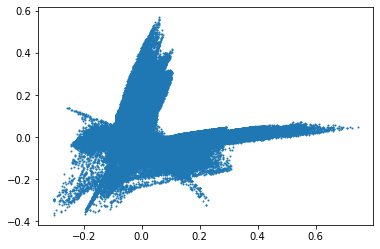

In [9]:
import matplotlib.pyplot as plt

if not pca_flag:
    plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], s=0.99)
else:
    plt.scatter(latent_pca[:, 0], latent_pca[:, 1], s=0.99)
plt.show()

1
1


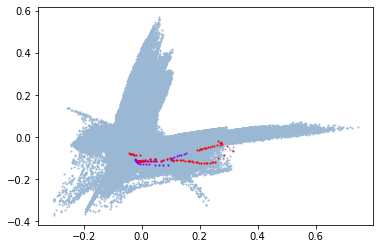

In [18]:
import matplotlib.cm as cm

# runs_dir = f'{model_path}runs/'
runs_dir = '/home/yigit/Desktop/cnmp_test_ls:128/moving/'
try:
    os.mkdir(runs_dir)
except:
    pass

latent_states_by_traj = []
for run in os.listdir(runs_dir):
    if run.endswith('.npy'):
        tmp_run = np.load(os.path.join(runs_dir, run))
        len_tmp_run = len(tmp_run)

        latent_states_of_cur_traj = np.zeros((len_tmp_run-1, latent_shape[2]))  # (num_states, 64)

        target_X_gamma = np.array([tmp_run[-1][0], tmp_run[-1][1], tmp_run[-1][2], tmp_run[-1][3]]).reshape(1, 1, d_x+d_gamma)  # x|gamma
        for i in range(1, len_tmp_run):  # first steps are wrong
            observation = tmp_run[i].reshape(1, 1, d_x+d_gamma+d_y)
            latent_repr_of_state = latent_layer.predict([observation, target_X_gamma]).reshape(1, latent_shape[2])
            latent_states_of_cur_traj[i-1] = latent_repr_of_state

        latent_states_by_traj.append(latent_states_of_cur_traj)

#######

x = np.arange(10)
ys = [i+x+(i*x)**2 for i in range(len(latent_states_by_traj))]
colors = cm.rainbow(np.linspace(0, 1, len(ys)))
    
if not pca_flag:
#     latent_states_tsne = tsne.transform(latent_states)
    plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], s=0.99)
#     plt.scatter(latent_states_tsne[:, 0], latent_states_tsne[:, 1], s=0.99, color='red')
else:
    plt.scatter(latent_pca[:, 0], latent_pca[:, 1], s=0.99, color='#9ab7d3')
    for traj, c in zip(latent_states_by_traj, colors):
        print('1')
        latent_states_by_traj_pca = pca.transform(traj)
        plt.scatter(latent_states_by_traj_pca[:-50, 0], latent_states_by_traj_pca[:-50, 1], s=0.99, color=c)
plt.show()